## 准备工作
导入一些公共模块：比如使用MatplotLib绘制图形并保存。检查Python以及Scikit-Learn版本……

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 一、MNIST
MNIST数据集——是一组由美国高中生和人口调查局员工手写的70 000个数字的图片。每张图片都用其代表的数字标记。

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Scikit-Learn加载的数据集通常具有类似的字典结构，包括：
* DESCR键，描述数据集。
* data键，包含一个数组，每个实例为一行，每个特征为一列。
* target键，包含一个带有标记的数组。

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

共有7万张图片，每张图片有784个特征。因为图片是28×28像素，每个特征代表了一个像素点的强度，从0（白色）到255（黑色）。

绘制显示其中一个实例的特征：

Saving figure some_digit_plot


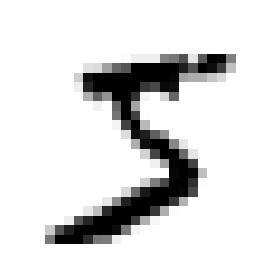

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)
y[0]

5

In [9]:
# 测试集和训练集的划分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 二、训练二元分类器

先简化问题，只尝试识别一个数字，比如数字5。那么这个“数字5检测器”就是一个二元分类器的示例，它只能区分两个类别：5和非5。先为此分类任务创建目标向量：

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ...,  True, False, False])

In [11]:
# 使用Scikit-Learn的SGDClassifier分类器
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 三、性能测量
### 1、使用交叉验证测量准确率
用cross_val_score（）函数来评估SGDClassifier模型，采用K-折交叉验证法（3个折叠）。

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

> 需要注意：准确率通常无法成为分类器的首要性能指标，特别是当你处理有偏数据集时（即某些类比其他类更为频繁）。

### 2、混淆矩阵
评估分类器性能的更好方法是混淆矩阵，其总体思路就是统计A类别实例被分成为B类别的次数。

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

与cross_val_score（）函数一样，cross_val_predict（）函数同样执行K-折交叉验证，但返回的不是评估分数，而是每个折叠的预测。这意味着对于每个实例都可以得到一个干净的预测（“干净”的意思是模型预测时使用的数据在其训练期间从未见过）。

使用confusion_matrix（）函数来获取混淆矩阵。只需要给出目标类别（y_train_5）和预测类别（y_train_pred）即可：

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

混淆矩阵中的行表示实际类别，列表示预测类别。本例中第一行表示所有“非5”（负类）的图片中：53892张被正确地分为“非5”类别（真负类），687张被错误地分类成了“5”（假正类）；第二行表示所有“5”（正类）的图片中：1891张被错误地分为“非5”类别（假负类），3530张被正确地分在了“5”这一类别（真正类）。

一个完美的分类器只有真正类和真负类，所以它的混淆矩阵只会在其对角线（左上到右下）上有非零值：

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**精度** = TP/(TP + FP)，TP是真正类的数量，FP是假正类的数量。

In [17]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1]/(cm[1, 1] + cm[0, 1])

0.8370879772350012

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

**召回率** = TP/(TP + FN)，FN是假负类的数量。

In [19]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

现在再看，当它说一张图片是5时，只有83.7%的概率是准确的，并且也只有65.1%的数字5被它检测出来了。

因此我们可以很方便地将精度和召回率组合成一个单一的指标，称为F1分数。当你需要一个简单的方法来比较两种分类器时，这是个非常不错的指标。F1分数是精度和召回率的谐波平均值。正常的平均值平等对待所有的值，而谐波平均值会给予低值更高的权重。因此，只有当召回率和精度都很高时，分类器才能得到较高的F1分数。

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1分数对那些具有相近的精度和召回率的分类器更为有利。

这不一定能一直符合你的期望：在某些情况下，你更关心的是精度，而另一些情况下，你可能真正关心的是召回率。例如，假设你训练一个分类器来检测儿童可以放心观看的视频，那么你可能更青睐那种拦截了很多好视频（低召回率），但是保留下来的视频都是安全（高精度）的分类器，而不是召回率虽高，但是在产品中可能会出现一些非常糟糕的视频的分类器（这种情况下，你甚至可能会添加一个人工流水线来检查分类器选出来的视频）。

反过来说，如果你训练一个分类器通过图像监控来检测小偷：你大概可以接受精度只有30%，但召回率能达到99%（当然，安保人员会收到一些错误的警报，但是几乎所有的窃贼都在劫难逃）。

遗憾的是，鱼和熊掌不可兼得，你不能同时增加精度又减少召回率，反之亦然。这称为精度/召回率权衡。

### 4、精度/召回率权衡
创建任意一个你想要的精度的分类器是相当容易的事情：只要阈值足够高即可！然而，如果召回率太低，精度再高，其实也不怎么有用！

### 5、ROC曲线
还有一种经常与二元分类器一起使用的工具，叫作受试者工作特征曲线（简称ROC）。它与精度/召回率曲线非常相似，但绘制的不是精度和召回率，而是真正类率（召回率的另一名称）和假正类率（FPR）。FPR是被错误分为正类的负类实例比率。它等于1减去真负类率（TNR），后者是被正确分类为负类的负类实例比率，也称为特异度。因此，ROC曲线绘制的是灵敏度（召回率）和（1-特异度）的关系。

绘制ROC曲线，首先需要使用roc_curve（）函数计算多种阈值的TPR和FPR：

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


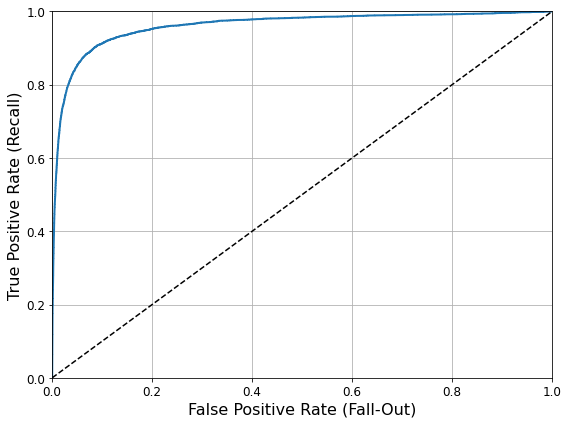

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

有一种比较分类器的方法是测量曲线下面积（AUC）。完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。

Scikit-Learn提供计算ROC AUC的函数：

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

训练一个RandomForestClassifier分类器，并比较它和SGDClassifier分类器的ROC曲线和ROC AUC分数

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

roc_curve（）函数需要标签和分数，但是我们不提供分数，而是提供类概率。我们直接使用正类的概率作为分数值：

In [27]:
y_scores_forest = y_probas_forest[:,1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [28]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

绘制ROC曲线了，也绘制第一条ROC曲线来看看对比结果

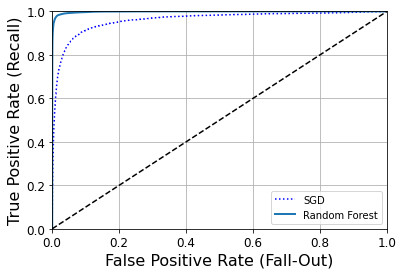

In [29]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

比较上图中ROC曲线：随机森林分类器优于SGD分类器，因为它的ROC曲线更靠近左上角，并且具有更大的AUC

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 四、多类分类器
二元分类器在两个类中区分，而多类分类器（也称为多项分类器）可以区分两个以上的类。

有一些算法（如随机森林分类器或朴素贝叶斯分类器）可以直接处理多个类。也有一些严格的二元分类器（如支持向量机分类器或线性分类器）。但是，有多种策略可以让你用几个二元分类器实现多类分类的目的。
* 一对剩余（OvR）策略，也称为一对多（one-versus-all）。
* 一对一（OvO）策略。

Scikit-Learn可以检测到你尝试使用二元分类算法进行多类分类任务，它会根据情况自动运行OvR或者OvO。

我们用sklearn.svm.SVC类来试试SVM分类器，这段代码使用原始目标类0到9（y_train）在训练集上对SVC进行训练

In [31]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) 
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [33]:
np.argmax(some_digit_scores)

5

In [34]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
svm_clf.classes_[5]

5

从上可见，最高分确实是对应数字5这个类别

In [40]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
len(ovr_clf.estimators_)

10

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [43]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

## 五、多标签分类
在某些情况下，我们希望分类器为每个实例输出多个类别。比如在一张照片中识别出多个人的脸，并附上标签。

下面这段代码会创建一个y_multilabel数组，其中包含两个数字图片的目标标签：第一个表示数字是否是大数（7、8、9），第二个表示是否为奇数。下一行创建一个KNeighborsClassifier实例（它支持多标签分类，不是所有的分类器都支持），然后使用多个目标数组对它进行训练。

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [47]:
# 现在用它做一个预测，会输出两个标签：
# knn_clf.predict([some_digit])